In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
import time
from elasticsearch import Elasticsearch
from datetime import date, datetime, time, timedelta
import pytz

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


****** Extracting tweets since 2018-08-20 14:00:00 ******

 ------ Iteration 1 of 2 ------
GV_scroll_size : 693

 ------ Iteration 2 of 2 ------
GV_scroll_size : 606


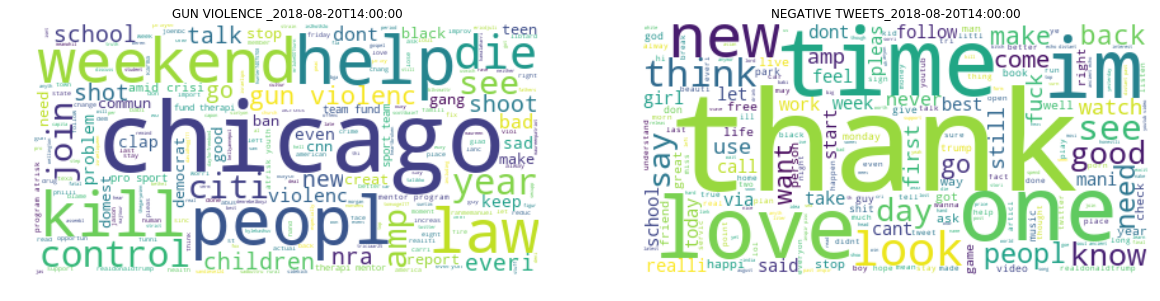

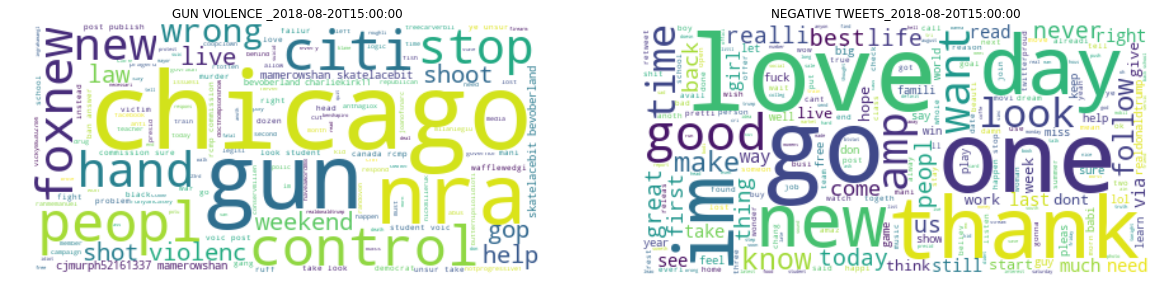

In [2]:
#trends_df = pd.read_csv('trends_df_2018-08-17T16:00:00.csv', index_col=0)
#summary_df = pd.read_csv('summary_df_2018-08-17T16:00:00.csv', index_col=0)
#summary_df.columns = range(12)
origin = datetime(2018,7,19, 20, 0, 0)
start_time = datetime(2018,8,20, 14, 0, 0)
#start_time = origin
diff = datetime.utcnow() - start_time
total_hours = int(np.ceil(diff.total_seconds()/3600))
print("******", "Extracting tweets since", start_time, "******", sep = " ")
flag = 0
for hour in range(total_hours):  
    print("\n", "------", "Iteration", hour + 1,"of", total_hours, "------" ,sep = " ")
    gte = (start_time - timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%S")
    lt = start_time.strftime("%Y-%m-%dT%H:%M:%S")
    
    es = Elasticsearch("http://54.242.41.222:9200/")
    doc = {
        'size' : 10000,
        'query': {
            'range' : {
                '@timestamp':{
                    "gte" : gte,
                    "lt" : lt
                }
            }
        }
    }
    
    # Data for positive Tweets
    gv_first_page = es.search(index="gun_violence", doc_type='doc', body=doc, scroll='1m')
    sid = gv_first_page['_scroll_id']
    gv_scroll_size_total= gv_scroll_size = gv_first_page['hits']['total']
    gv_final_hits = gv_first_page['hits']['hits']
    print("GV_scroll_size :", gv_scroll_size)
    while (gv_scroll_size > 0):
        #print("Scrolling...")
        gv_new_page = es.scroll(scroll_id = sid, scroll = '1m')
        new_hits = gv_new_page['hits']['hits']
        # Update the scroll ID
        sid = gv_new_page['_scroll_id']
        # Get the number of results that we returned in the last scroll
        gv_scroll_size = len(gv_new_page['hits']['hits'])
        #print("scroll size: " + str(gv_scroll_size))
        gv_final_hits = gv_final_hits + new_hits

    json_gunViolence = gv_final_hits
    gunViolence = [d['_source'] for d in json_gunViolence]
    gunViolence = pd.DataFrame(gunViolence)
    gunViolence['type']='gun violence'
    gunViolence["text"]= gunViolence["text"].str.replace("gun", "")
    gunViolence["text"]= gunViolence["text"].str.replace("violence", "")
    gunViolence["text"]= gunViolence["text"].str.replace('http\S+|www.\S+', '', case=False)
    #print("Shape before removing retweets:", np.shape(gunViolence))
    gunViolence = gunViolence[gunViolence.text.str.contains("RT") == False].reset_index(drop=True) #Remove all retweets
    #print("Shape after removing retweets:", np.shape(gunViolence))
    
    # Data for negative Tweets
    non_gv_first_page = es.search(index="negative_sample", doc_type='doc', body=doc, scroll='1m')
    sid = non_gv_first_page['_scroll_id']
    non_gv_scroll_size_total = non_gv_scroll_size = 2 * gv_first_page['hits']['total']
    non_gv_final_hits = non_gv_first_page['hits']['hits']
    #print("NT_scroll_size :", non_gv_scroll_size)
    while (non_gv_scroll_size > 0):
        #print("Scrolling...")
        non_gv_new_page = es.scroll(scroll_id = sid, scroll = '1m')
        new_hits = non_gv_new_page['hits']['hits']
        # Update the scroll ID
        sid = non_gv_new_page['_scroll_id']
        # Get the number of results that we returned in the last scroll
        non_gv_scroll_size = len(non_gv_new_page['hits']['hits'])
        #print("scroll size: " + str(non_gv_scroll_size))
        non_gv_final_hits = non_gv_final_hits + new_hits

    json_negativeTweets = non_gv_final_hits
    negativeTweets = [d['_source'] for d in json_negativeTweets]
    negativeTweets = pd.DataFrame(negativeTweets)
    negativeTweets['type']='negative tweets'
    negativeTweets["text"]= negativeTweets["text"].str.replace('http\S+|www.\S+', '', case=False)
    #print("Shape before removing retweets:", np.shape(negativeTweets))
    negativeTweets = negativeTweets[negativeTweets.text.str.contains("RT") == False].reset_index(drop=True) #Remove all retweets
    #print("Shape after removing retweets:", np.shape(negativeTweets))
    
    #Concat both tweets
    tweets = pd.concat([gunViolence, negativeTweets])
    tweets= tweets.iloc[np.random.permutation(len(tweets))].reset_index(drop=True)
    tweets['text']= tweets['text'].apply(str)

    data= tweets[['type','text']]
    data.dropna(inplace=True)
    data['type'].value_counts()
    
    # remove whitespaces
    data['text']=data['text'].str.strip()

    # lowercase the text
    data['text'] = data['text'].str.lower()

    #remove punctuation
    punc = string.punctuation
    table = str.maketrans('','',punc)
    data['text']=data['text'].apply(lambda x: x.translate(table))

    # tokenizing each message
    data['word_tokens']=data.apply(lambda x: x['text'].split(' '),axis=1)

    # removing stopwords
    cachedStopWords = stopwords.words("english")
    data['cleaned_text']= data.apply(lambda x: [word for word in x['word_tokens'] if word not in cachedStopWords],axis=1)

    # stemming
    ps = PorterStemmer()
    data['stemmed']= data.apply(lambda x: [ps.stem(word) for word in x['cleaned_text']],axis=1)

    # remove single letter words
    data['final_text'] = data.apply(lambda x: ' '.join([word for word in x['stemmed'] if len(word)>1]),axis=1)

    # label encoding negative tweets=0 and gun violence tweets=1
    data.loc[data['type']=='negative tweets','type']=0
    data.loc[data['type']=='gun violence','type']=1

    # divide the set in training and test
    from sklearn.model_selection import train_test_split
    X,X_test,y,y_test = train_test_split(data.loc[:,'text':],data['type'],test_size=0.2)

    # Now we'll create a vocabulary for the training set with word count
    vocab=defaultdict(int) 
    for text in X['final_text'].values:
        for elem in text.split(' '):
            vocab[elem]+=1

    # Now we look at the types of words in gun_violence and non_gun_violence tweets. We plot wordclouds for both
    nt_text=' '.join(X.loc[y==0,'final_text'].values)
    nt_wordcloud = WordCloud(background_color='white',max_words=2000).generate(nt_text)
    gv_text=' '.join(X.loc[y==1,'final_text'].values)
    gv_wordcloud = WordCloud(background_color='white',max_words=2000).generate(gv_text)
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(gv_wordcloud,interpolation='bilinear')
    plt.title('GUN VIOLENCE _' + lt)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(nt_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('NEGATIVE TWEETS_' + lt)
    plt.savefig('WORD CLOUD_' + lt + '.png')

    # tokenize the text for further calculations
    X['tokenized_final_text']=X['final_text'].str.split(' ')
    X_test['tokenized_final_text']=X_test['final_text'].str.split(' ')

    # document frequency(number of docs containing word w) and Inverse document frequency(measures rarity of each word)
    df={}
    for k in vocab.keys():
        df[k]=np.sum(X['tokenized_final_text'].apply(lambda x: 1 if k in x else 0))

    # Now we'll calculate the idf score of each word
    idf = {k:1+np.log((1+X.shape[0]/(1+v))) for k,v in df.items()}

    # tf * idf
    for elem in vocab.keys():
        X[elem]= X['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)
    for elem in vocab.keys():
        X_test[elem]= X_test['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)

    y=y.astype('int')
    y_test = y_test.astype('int')

    #Logistic Regression 
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()
    lr.fit(X.iloc[:,6:],y)
    
    gv_50  = np.argsort(lr.coef_)[0][-50:]

    features = X.iloc[:,6:].columns
    
    cm = confusion_matrix(y,lr.predict(X.iloc[:,6:]))
    tf_idf_size = np.shape(X.iloc[:,6:])[1]
    f1 = f1_score(y_test,lr.predict(X_test.iloc[:,6:]))
    accuracy = accuracy_score(y_test,lr.predict(X_test.iloc[:,6:]))
    precision = precision_score(y_test,lr.predict(X_test.iloc[:,6:]))
    recall = recall_score(y_test,lr.predict(X_test.iloc[:,6:]))
    
    trends_new_row = pd.Series(data=features[gv_50], name= lt)
    summary_new_row = pd.Series(data = [lt, gv_scroll_size_total, non_gv_scroll_size_total, tf_idf_size ,f1,accuracy, precision, recall ,cm[0][0], cm[0][1], cm[1][0], cm[1][1]])
    
    if flag == 0:
        trends_df = pd.DataFrame([])
        trends_df = trends_df.append(trends_new_row, ignore_index=True)
        summary_df = pd.DataFrame([])
        summary_df = summary_df.append(summary_new_row, ignore_index=True)
        flag = 1
    else: 
        trends_df = trends_df.append(trends_new_row, ignore_index=True)
        summary_df = summary_df.append(summary_new_row, ignore_index=True)
        
    start_time = start_time + timedelta(hours = 1)

In [3]:
summary_df.columns = ['datetime', 'gv_size', 'non_gv_size', 'tf_idf_size', 'f1_score', 'accuracy', 'precision','recall','TP','FP', 'TN', 'FN'] 
trends_df.to_csv("trends_df_" + lt + ".csv")
summary_df.to_csv("summary_df_" + lt + ".csv")

In [4]:
summary_df

,datetime,gv_size,non_gv_size,tf_idf_size,f1_score,accuracy,precision,recall,TP,FP,TN,FN
0,2018-08-20T14:00:00,693.0,1386.0,4466.0,0.142857,0.915789,0.666667,0.080000,1037.0,0.0,0.0,100.0
1,2018-08-20T15:00:00,606.0,1212.0,4604.0,0.451613,0.944079,0.875000,0.304348,1111.0,0.0,2.0,99.0


In [5]:
trends_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,effort,member,left,fire,blame,glad,70,read,kick,sad,...,democrat,violenc,ceas,toler,🥓🙏🏻❤️🇺🇸,kamalaharri,question😡,you👊,😄😄😄😂😂😂,chicago
1,skatelacebit,mamerowshan,alter,governor\ngovraun,governor\ncmon,black,suppos,chrismurphyct,ct,insid,...,tragedi,,campaign,gun,citi,retali,polic,mondaymotiv,every\nsingle\ntim,chicago


In [10]:
gunViolence

,@timestamp,id,lang,state,text,user_location,user_name,user_screen_name,user_statuses_count,user_verified,type
0,2018-08-20T14:04:16.000Z,1031542434667356161,en,Not Defined,@PoliceUg @metpoliceug @pwatchug. Violence mus...,kampala,God bless 🇺🇬,Sents_Roy,640,False,gun violence
1,2018-08-20T14:07:05.000Z,1031543144599437316,en,VA,53 teachers and students fatally shot in Orego...,"Fairfax, Virginia",NRA Tally,NRA_Tally,9845,False,gun violence
2,2018-08-20T14:07:28.000Z,1031543240984604672,en,Not Defined,Lost in . \nGun fire inside my head.,pimptown,riches,PimPicasso,1034,False,gun violence
3,2018-08-20T14:10:58.000Z,1031544120194433025,en,UT,"universal background checks, restraining ord...","Salt Lake City, UT",Madalena McNeil,madalenamcneil,17772,False,gun violence
4,2018-08-20T14:08:28.000Z,1031543492105981952,en,Not Defined,Antifa Protesters Blare ‘F*** the Police’ Duri...,None,Darlene Duling,DulingDarlene,69335,False,gun violence
5,2018-08-20T14:29:30.000Z,1031548787976622080,en,Not Defined,2/3's are suicides.\n\nOwner-induced death.\n\...,Gardener State (aka Socialist State of Commief...,Out of Bubblegum ❌,2016Republic,88,False,gun violence
6,2018-08-20T14:26:38.000Z,1031548063335305216,en,Not Defined,@CoopClown @NickMillerUK @prageru @DocThompson...,None,Anita Little Sunshine,AnitaLittleSun1,1773,False,gun violence
7,2018-08-20T14:30:05.000Z,1031548931866537984,en,Not Defined,@TorontosMayor @JohnTory Why don’t you stop wh...,None,john steel,johnste51887525,289,False,gun violence
8,2018-08-20T14:36:57.000Z,1031550659055820801,en,Not Defined,#Chicago I don’t get it. Why not send in the #...,"USA, UK, All over the Globe",J,indigoblue65,74216,False,gun violence
9,2018-08-20T14:35:55.000Z,1031550400263069696,en,TX,This has to stop! God Bless all these families...,"Texas, USA",codysmom92,codysmom92,2693,False,gun violence


In [11]:
print(datetime.utcnow())

2018-08-20 15:43:13.716395
